### Problem Set 2

#### Done by **Fatykhoph Denis** in Skoltech, Planning Algo-s, 2024

### Task1. Visualization

In [8]:
import pickle
import numpy as np
from environment import State, ManipulatorEnv

%matplotlib inline
import matplotlib.pyplot as plt
import angle_util as au
from icecream import ic
from typing import List

In [9]:
a = np.array([20., 30., 40.])
b = np.array([15., 45., 78.])

ic(au.angle_linspace(a, b, n=5))
ic(au.angle_difference(a, b))

ic| au.angle_linspace(a, b, n=5): array([[20. , 30. , 40. ],
                                         [19. , 33. , 47.6],
                                         [18. , 36. , 55.2],
                                         [17. , 39. , 62.8],
                                         [16. , 42. , 70.4],
                                         [15. , 45. , 78. ]])
ic| au.angle_difference(a, b): array([  5., -15., -38.])


array([  5., -15., -38.])

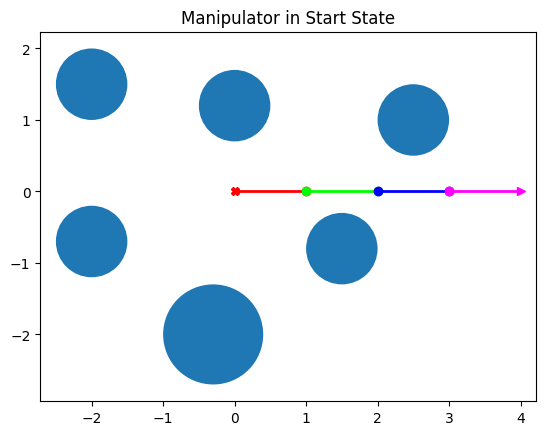

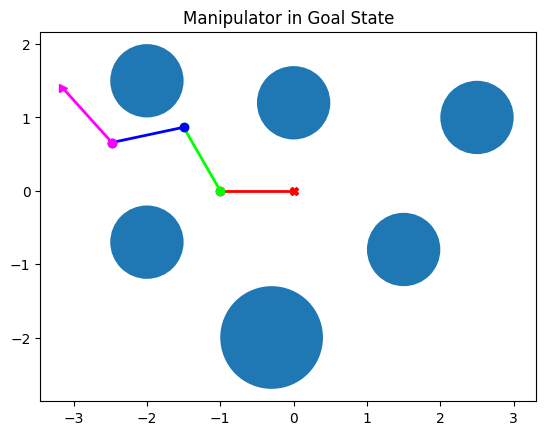

In [10]:
# Load data from the pickle file
with open("data.pickle", "rb") as f:
    data = pickle.load(f)

start_state = State(np.array(data["start_state"]))
goal_state = State(np.array(data["goal_state"]))
obstacles = np.array(data["obstacles"])
collision_threshold = data["collision_threshold"]

# Create environment with start state
env = ManipulatorEnv(obstacles=obstacles,
                    initial_state=start_state,
                    collision_threshold=collision_threshold)

plt.figure()
plt.title("Manipulator in Start State")
env.render(plt_show=True)

env.state = goal_state

plt.figure()
plt.title("Manipulator in Goal State")
env.render(plt_show=True)

In the previous problem set (PS1) with *discretized orientation space*, the *state space was finite*, which allowed for simpler algorithms like *Dijkstra* or *Astar* to be applied directly. However, this comes at the cost of granularity: higher precision requires finer discretization, leading to exponential growth in states.

In contrast, this problem set uses a *continuous orientation space*. While it provides higher precision and more realistic modeling of the manipulator's motion, it complicates planning as we must use advanced techniques like sampling-based algorithms to explore the infinite state space effectively.

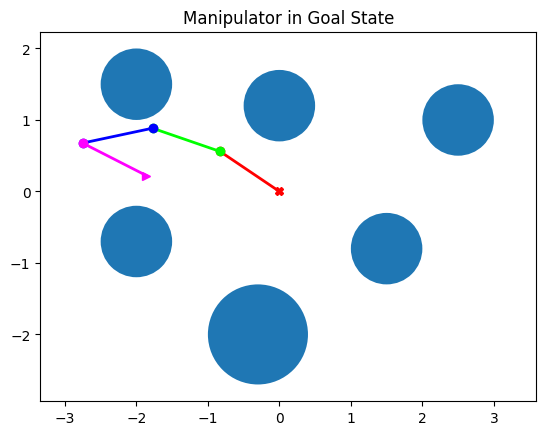

Attention!!! Collision detected in link (3, 4) joint on coordinates: [-1.43 -0.79]


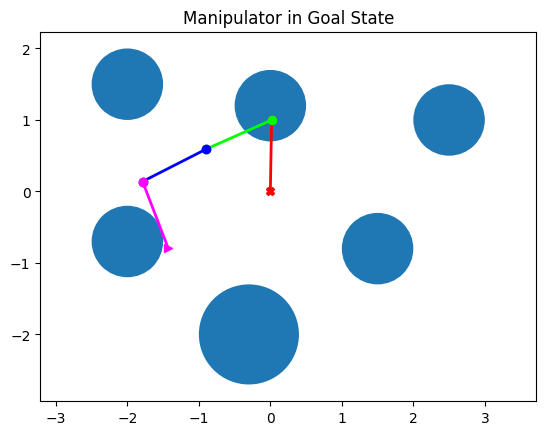

Attention!!! Collision detected in link (3, 4) joint on coordinates: [ 0.97 -0.8 ]


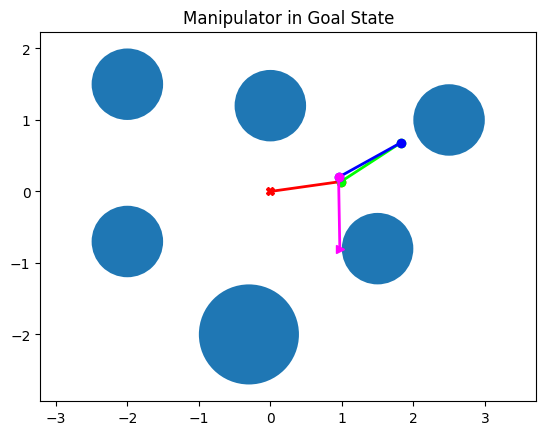

Attention!!! Collision detected in link (0, 1) joint on coordinates: [0.19 0.98]


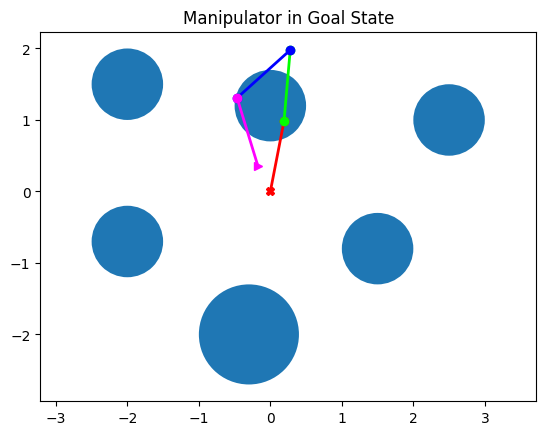

In [12]:
for i in range(0, 4):
    i += 1
    env.state = State(np.random.randint(0, 180, 4).astype(float))

    plt.figure()
    plt.title("Manipulator in Goal State")
    condition, point = env.check_collision(env.state)
    if (condition):
        print(
            f'Attention!!! Collision detected '
            f'in link {point['link_segment']} '
            f'joint on coordinates: {np.round(point['collision_point'], 2)}'
        )
    env.render(plt_show=True)

Originally, the function `ManipulatorEnv.check_collision` was proposed to detect collision for our manipulator. It was working well, and each time at least one joint or part of link was in collision with objects it returned boolean `True`. Which indicated to us that our robot in collision.

But, I modified it a little bit. So, for now, if function detects collision it returns not only the indicator for collision, but also the link which in collision and coordinates of joint, who created this situation.   

### Task2. Rapidly-exploring Random Trees

In [13]:
def config_creation(
                    arbitrary_increment: int,
                    linspace_step: int,
                    q_init: np.ndarray = np.nan,
                    q_goal: np.ndarray = np.nan
                    ) -> List:
    """
    Generates random angle_linspase 

    :param arbitrary_increment: with this variable you can control 
                                scaling of goal configuration according
                                to the initial configuration
    :param linspace_step: variable which denotes the size of linspace
    :param q_init: allows to manually setup initial state of system 
    :param q_goal: allows to manually setup goal state of system

    :return: List.
            a sequence of configurations connecting initial configuration
            and goal configuration
    """
    if np.isnan(q_init).any():
        q_init = np.random.randint(0, 180, 4).astype(float)

    if np.isnan(q_goal).any():
        while True:
            q_goal = np.round((2)**(np.random.random()) * q_init)
            if (np.abs(q_goal) >= 0.0).all() and (np.abs(q_goal) <= 180.0).all():
                break

    linspace_configs = au.angle_linspace(q_init, q_goal, linspace_step)

    return [State(angles) for angles in linspace_configs]

[42. 91. 76. 28.]
Attention!!! Collision detected in link (1, 2) joint on coordinates: [0.06 1.4 ]
[45.5 98.5 82.5 30.5]
Attention!!! Collision detected in link (1, 2) joint on coordinates: [-0.11  1.3 ]
[ 49. 106.  89.  33.]
Attention!!! Collision detected in link (1, 2) joint on coordinates: [-0.25  1.18]


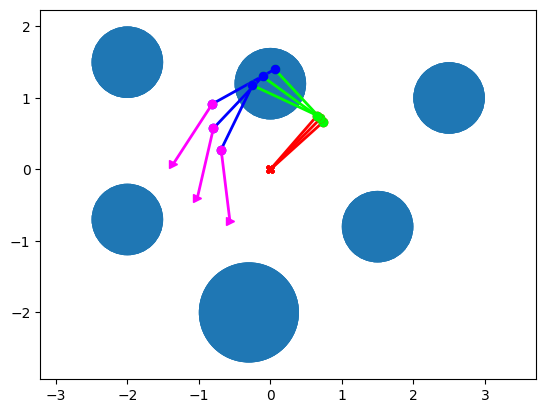

In [26]:
config_space = config_creation(arbitrary_increment=10,
                                linspace_step=2)
for state in config_space:
    print(state.angles)
    env.state = state
    condition, point = env.check_collision(env.state)
    if (condition):
        print(
            f'Attention!!! Collision detected '
            f'in link {point['link_segment']} '
            f'joint on coordinates: {np.round(point['collision_point'], 2)}'
        )
    else:
        print('No collision detected')
    env.render(plt_show=False)

[35. 20. 68. 27.]
No collision detected
[93.  27.5 93.  37. ]
Attention!!! Collision detected in link (0, 1) joint on coordinates: [-0.05  1.  ]
[151.  35. 118.  47.]
No collision detected


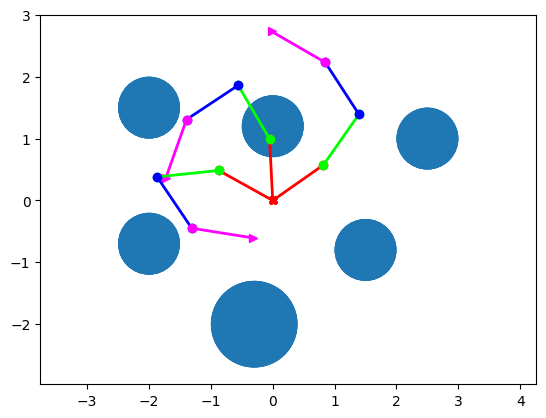

In [93]:
config_space = config_creation(10, 2, 
                q_init=np.array([35., 20., 68., 27.]),
                q_goal=np.array([151., 35., 118., 47.]))
for state in config_space:
    print(state.angles)
    env.state = state
    condition, point = env.check_collision(env.state)
    if (condition):
        print(
            f'Attention!!! Collision detected '
            f'in link {point['link_segment']} '
            f'joint on coordinates: {np.round(point['collision_point'], 2)}'
        )
    else:
        print('No collision detected')
    env.render(plt_show=False)

Completing this part of task helped me to understand how to work with `angle_util.py`. Moreover, I chose a sequence of 3 because this is the minimum set needed to demonstrate the required state. However, the `angle_linspace` function allows us to achieve any required n discretization of the continuous space between the initial and final states.

Below I just played with creation rrt for points, not for manipulator. You can skip it

In [40]:
def rrt_creation(
                    arbitrary_increment: int,
                    linspace_step: int,
                    q_init: np.ndarray = np.nan,
                    q_goal: np.ndarray = np.nan,
                    norm_type: int = 1,
                    max_rot: float = 10.
                    ) -> List:
    """
    Generates random angle_linspase 

    :param arbitrary_increment: with this variable you can control 
                                scaling of goal configuration according
                                to the initial configuration
    :param linspace_step: variable which denotes the size of linspace
    :param q_init: allows to manually setup initial state of system 
    :param q_goal: allows to manually setup goal state of system
    :param norm_type: default is Manhattan norm
    :param mar_rot: maximum allowed rotation for each joint

    :return: List.
            a sequence of configurations connecting initial configuration
            and goal configuration
    """
    if np.isnan(q_init.all()):
        q_init = np.random.randint(0, 180, 4).astype(float)
    
    linspace_configs = np.array(q_init)
    linspace_configs = linspace_configs[None, :]

    if np.isnan(q_goal.all()):
        while True:
            q_goal = np.round((2)**(np.random.random()) * q_init)
            if (np.abs(q_goal) >= 0.0).all() and (np.abs(q_goal) <= 180.0).all():
                break

    q_random = np.array(q_init)

    while np.linalg.norm((q_goal - q_random), norm_type) >= max_rot:
        q_random = np.random.randint(0, 180, 4).astype(float)

        if np.linalg.norm((q_random - linspace_configs[-1]), norm_type) >= max_rot:
            continue
        if (np.abs(au.angle_difference(q_random, linspace_configs[-1])) >= max_rot).all():
            continue

        linspace_configs  = np.vstack((linspace_configs, q_random))

    return [State(angles) for angles in linspace_configs]

In [ ]:
config_space = rrt_creation(10, 2, 
                q_init=np.array([0., 0., 0., 0.]),
                q_goal=np.array([-180., -60., 72., -60.]))
for state in config_space:
    print(state.angles)
    env.state = state
    condition, point = env.check_collision(env.state)
    if (condition):
        print(
            f'Attention!!! Collision detected '
            f'in link {point['link_segment']} '
            f'joint on coordinates: {np.round(point['collision_point'], 2)}'
        )
    else:
        print('No collision detected')
    env.render(plt_show=False)

Few functions implemented for usage in main algorithm

In [51]:
def compute_weighted_distance(state_a, state_b):
    scaling_factors = np.array([1.2, 1.1, 1.05, 1.0])
    angle_diffs = au.angle_difference(state_a, state_b)
    absolute_diffs = np.abs(np.array(angle_diffs))
    weighted_diffs = scaling_factors * absolute_diffs
    total_distance = np.sum(weighted_diffs)
    return total_distance


def reconstruct_array_path(goal_node):
    """Reconstruct the path from the goal node to the root."""
    path = []
    current_node = goal_node
    while current_node is not None:
        path.append(current_node.value.tolist())
        current_node = current_node.parent
    return path[::-1] 


def generate_random_state(q_goal, state_space_root, method=1, 
                          min_bounds=-180, max_bounds=180):
    """
    Generate a random state (q_random) using one of the specified methods.

    :param q_goal: Goal configuration as a numpy array.
    :param state_space_root: The root configuration (numpy array).
    :param method: Integer specifying the method to use:
                   1 - Global Sampling
                   2 - Goal Sampling
                   3 - Informed Sampling (Heuristic-Based)
    :param min_bounds: Minimum bounds for each dimension.
    :param max_bounds: Maximum bounds for each dimension.
    :return: A random state as a numpy array.
    """
    if method == 1:
        # Global Sampling
        return np.random.uniform(min_bounds, max_bounds, size=q_goal.shape)

    elif method == 2:
        # Goal Sampling
        return np.random.uniform(
                np.min([state_space_root.value, q_goal], axis=0),
                np.max([state_space_root.value, q_goal], axis=0)
                )

    elif method == 3:
        # Informed Sampling (Heuristic-Based)
        distance_to_goal = np.linalg.norm(q_goal - state_space_root.value)
        lower_bound = np.maximum(q_goal - distance_to_goal, min_bounds)
        upper_bound = np.minimum(q_goal + distance_to_goal, max_bounds)
        return np.random.uniform(lower_bound, upper_bound, size=q_goal.shape)

    else:
        raise ValueError("Invalid method selected. Choose 1, 2, or 3.")

In [27]:
class Node:
    def __init__(self, value, parent=None):
        self.value = value 
        self.children = []  
        self.parent = parent 


    def add_child(self, child_node):
        """Add a child node to the current node."""
        self.children.append(child_node)


    def __repr__(self):
        return f"Node({self.value})"
        


In [69]:
class Tree:
    def __init__(self, root_value):
        self.root = Node(root_value) 


    def add_node(self, parent_value, child_value):
        """Add a child node under the specified parent node."""
        parent_node = self.find_node(self.root, parent_value)
        if parent_node:
            parent_node.add_child(Node(child_value))


    def find_node(self, current_node, value):
        """Recursively search for a node with the given value."""
        if np.array(current_node.value == value).all():
            return current_node
        for child in current_node.children:
            found_node = self.find_node(child, value)
            if found_node:
                return found_node
        return None


    def find_child(self, current_node):
        return True


    def find_neighbor(
        self, current_node,
        value, boundary=0.5,
        norm_type=1) -> bool:
        """Find and connect a neighbor within a specified boundary."""
        if np.linalg.norm(np.array([current_node.value - value]), ord=norm_type) <= boundary:
            new_node = Node(value, parent=current_node)
            current_node.add_child(new_node)
            return True

        for child in current_node.children:
            found_neighbor = self.find_neighbor(child, value, boundary)
            if found_neighbor:
                return found_neighbor
        return False


    def display(self, node=None, level=0):
        """Display the tree structure."""
        if node is None:
            node = self.root
        print(' ' * level * 4 + str(node.value))
        for child in node.children:
            self.display(child, level + 1)

In [52]:
class Tree:
    def __init__(self, root_value):
        self.root = Node(root_value)  # Initialize the tree with a root node

    def find_node(self, current_node, value):
        """Recursively search for a node with the given value."""
        if np.array_equal(current_node.value, value):
            return current_node
        for child in current_node.children:
            found_node = self.find_node(child, value)
            if found_node:
                return found_node
        return None

    def find_neighbor(
        self, current_node,
        value, boundary=0.5,
        norm_type=1,
        custom_norm:bool = False) -> bool:
        """Find and connect a neighbor within a specified boundary."""
        if custom_norm:
            if compute_weighted_distance(current_node.value, value) <= boundary:
                new_node = Node(value, parent=current_node)
                current_node.add_child(new_node)
                return True            
        else:
            if np.linalg.norm(np.array([current_node.value - value]), ord=norm_type) <= boundary:
                new_node = Node(value, parent=current_node)
                current_node.add_child(new_node)
                return True

        for child in current_node.children:
            found_neighbor = self.find_neighbor(child, value, boundary, norm_type)
            if found_neighbor:
                return found_neighbor
        return False

    def find_all_leaf_nodes(self, current_node=None, leaves=None):
        """
        Find all leaf nodes (nodes without children) in the tree.
        """
        if leaves is None:
            leaves = []
        if current_node is None:
            current_node = self.root

        if not current_node.children:  # If no children, it's a leaf
            leaves.append(current_node)
        else:
            for child in current_node.children:
                self.find_all_leaf_nodes(child, leaves)
        return leaves

    def add_to_nearest_leaf(
            self, q_random, boundary,
            env: ManipulatorEnv, norm_type=1):
        """
        Add a new node to the nearest leaf node in the direction of q_random.

        :param q_random: Target state (numpy array).
        :param boundary: Maximum allowable distance for the new node.
        :param norm_type: Norm type to use for distance calculation.
        """
        # Find all leaf nodes
        leaf_nodes = self.find_all_leaf_nodes()

        # Find the nearest leaf to q_random using the specified norm
        nearest_leaf = None
        min_distance = float("inf")
        for leaf in leaf_nodes:
            distance = np.linalg.norm(q_random - leaf.value, ord=norm_type)
            if distance < min_distance:
                min_distance = distance
                nearest_leaf = leaf

        # Steer from the nearest leaf toward q_random, constrained by boundary
        if nearest_leaf is not None:
            diff = q_random - nearest_leaf.value
            step = np.clip(diff, -boundary, boundary)  # Limit the step size
            new_state = nearest_leaf.value + step
            
            #collision check
            env.state = State(new_state)
            condition, _ = env.check_collision(env.state)
            if condition:
                return None

            new_node = Node(new_state, parent=nearest_leaf)
            nearest_leaf.add_child(new_node)
            return new_node
        return None

RRT algorithm **without collision**

In [31]:
leaf_init = np.array([0., 0., 0., 0.])
# leaf_goal = np.array([-180., -60., 72., -60.])
leaf_goal = np.array([10., 11., 12., 10.])

state_tree = Tree(leaf_init)

def rrt_array_algos(state_space: Tree, q_goal: np.ndarray, bound=1):
    
    while state_space.find_neighbor(state_space.root, q_goal, boundary=bound) is False:
        # q_random = np.random.uniform(
        # np.min([state_space.root.value, q_goal], axis=0),
        # np.max([state_space.root.value, q_goal], axis=0)
        # )
        q_random = generate_random_state(q_goal=q_goal,
                                        state_space_root=state_space.root,
                                        method=2)
        
        # ic(q_random)
        state_space.find_neighbor(state_space.root, np.round(q_random, 2), boundary=bound)
        # state_space.display()
    
    # state_space.display()

    # Find the goal node
    goal_node = state_space.find_node(state_space.root, q_goal)
    if goal_node:
        # Reconstruct the path
        path = reconstruct_array_path(goal_node)
        print(f"Shortest path: {path}")
    else:
        print("Goal node not found!")

    return path


linspace_final = rrt_array_algos(state_tree, leaf_goal, bound=2)

Shortest path: [[0.0, 0.0, 0.0, 0.0], [1.15, 0.07, 1.82, 0.67], [3.02, 0.96, 3.16, 2.06], [4.22, 2.44, 1.73, 1.14], [6.21, 1.06, 0.62, 2.07], [4.21, 1.69, 0.71, 3.52], [2.7, 2.87, 0.03, 4.26], [2.7, 4.34, 0.81, 5.32], [2.76, 3.34, 2.37, 6.81], [4.42, 5.3, 4.23, 4.95], [5.82, 6.29, 4.78, 6.08], [6.68, 6.9, 6.05, 5.41], [6.13, 5.85, 7.81, 6.65], [7.81, 5.99, 9.67, 8.6], [9.66, 6.86, 10.43, 9.0], [9.5, 8.07, 10.04, 7.38], [8.72, 9.4, 11.83, 8.51], [10.0, 11.0, 12.0, 10.0]]


[0. 0. 0. 0.]
No collision detected
[1.15 0.07 1.82 0.67]
No collision detected
[3.02 0.96 3.16 2.06]
No collision detected
[4.22 2.44 1.73 1.14]
No collision detected
[6.21 1.06 0.62 2.07]
No collision detected
[4.21 1.69 0.71 3.52]
No collision detected
[2.7  2.87 0.03 4.26]
No collision detected
[2.7  4.34 0.81 5.32]
No collision detected
[2.76 3.34 2.37 6.81]
No collision detected
[4.42 5.3  4.23 4.95]
No collision detected
[5.82 6.29 4.78 6.08]
Attention!!! Collision detected in link (2, 3) joint on coordinates: [2.93 0.6 ]
[6.68 6.9  6.05 5.41]
Attention!!! Collision detected in link (2, 3) joint on coordinates: [2.91 0.69]
[6.13 5.85 7.81 6.65]
Attention!!! Collision detected in link (2, 3) joint on coordinates: [2.91 0.65]
[7.81 5.99 9.67 8.6 ]
Attention!!! Collision detected in link (2, 3) joint on coordinates: [2.88 0.77]
[ 9.66  6.86 10.43  9.  ]
Attention!!! Collision detected in link (2, 3) joint on coordinates: [2.84 0.91]
[ 9.5   8.07 10.04  7.38]
Attention!!! Collision 

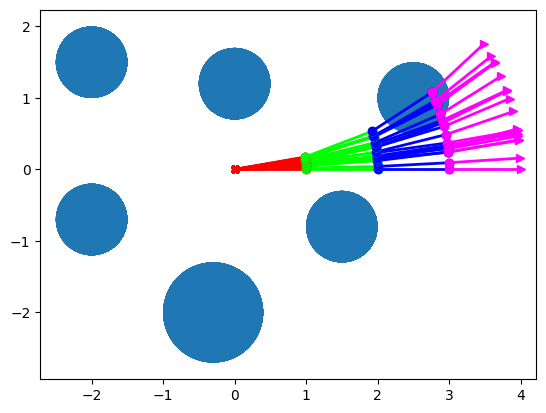

In [32]:
linspace_final = np.array(linspace_final)

for state in [State(angles) for angles in linspace_final]:
    print(state.angles)
    env.state = state
    condition, point = env.check_collision(env.state)
    if (condition):
        print(
            f'Attention!!! Collision detected '
            f'in link {point['link_segment']} '
            f'joint on coordinates: {np.round(point['collision_point'], 2)}'
        )
    else:
        print('No collision detected')
    env.render(plt_show=False)

**Main implementation**

In [ ]:
def rrt_array_algos_with_collision(
    state_space: Tree,
    q_goal: np.ndarray,
    obstacles: np.ndarray,
    collision_threshold: float = 0.1,
    node_bound=1,
    max_iterations=30000
):
    """
    RRT algorithm with collision avoidance and fallback to add nodes to the nearest leaf.

    :param state_space: The Tree object representing the state space.
    :param q_goal: The goal configuration as a numpy array.
    :param obstacles: Array representing obstacles in the environment.
    :param collision_threshold: Threshold for collision detection.
    :param node_bound: Maximum allowable distance for connecting nodes.
    :param max_iterations: Maximum iterations to grow the tree.
    :return: The path from start to goal as a list of configurations.
    """
    skip = 0
    test_env = ManipulatorEnv(
        obstacles=obstacles,
        initial_state=State(state_space.root.value),
        collision_threshold=collision_threshold
    )

    for iteration in range(max_iterations):
        # Check if we can directly connect to the goal
        if state_space.find_neighbor(state_space.root, q_goal, boundary=node_bound):
            print(f"Goal reached in {iteration + 1} iterations.")
            break

        # Generate a random configuration
        q_random = generate_random_state(
            q_goal=q_goal,
            state_space_root=state_space.root,
            method=1  # Global sampling
        )

        # Perform collision check
        test_env.state = State(q_random)
        condition, point = test_env.check_collision(test_env.state)
        if condition:
            skip += 1
            print(f"Skipped {skip} due to collision at {q_random}.")
            continue

        # Try to add the random configuration to the tree
        added = state_space.find_neighbor(state_space.root, np.round(q_random, 2), boundary=node_bound)
        if not added:
            # Fallback: Add a new node to the nearest leaf in the tree
            new_node = state_space.add_to_nearest_leaf(
                q_random, boundary=node_bound,
                env=test_env, norm_type=1
            )
            if new_node:
                print(f"Node added to the nearest leaf: {new_node.value}")

    # Find the goal node
    goal_node = state_space.find_node(state_space.root, q_goal)
    if goal_node:
        # Reconstruct the path
        path = reconstruct_array_path(goal_node)
        print(f"Shortest path: {path}")
        return path
    else:
        # print("Goal node not found!")
        return None

# Example input data
leaf_init = np.array([0.0, 0.0, 0.0, 0.0])
leaf_goal = np.array([-180.0, -60.0, 72.0, -60.0])

state_tree = Tree(leaf_init)

linspace_final_without_collision = rrt_array_algos_with_collision(
    state_space=state_tree,
    q_goal=leaf_goal,
    obstacles=np.array(data["obstacles"]),
    collision_threshold=data["collision_threshold"],
    node_bound=15
)

Skipped 1 due to collision at [-18.84697348 -40.17831986 145.84282655 107.58562075].
Skipped 2 due to collision at [-11.6565662   18.67413579  48.64828744  89.90701521].
Skipped 3 due to collision at [ -91.80121213   -8.66391637   19.67736676 -107.94270116].
Skipped 4 due to collision at [-177.67339047 -155.0757206    94.00307702  137.77086286].
Skipped 5 due to collision at [-129.41115661  -58.77016343  112.55439173 -131.57753636].
Skipped 6 due to collision at [122.77137299 144.18465367 161.64497307 -24.22141226].
Skipped 7 due to collision at [ 73.52986481 -85.89002636 -93.453668    50.90717108].
Skipped 8 due to collision at [-52.36032457 105.17308403  43.38012033 -96.29190879].
Skipped 9 due to collision at [  91.12109467  146.84392212 -118.92242248 -117.42687483].
Skipped 10 due to collision at [ 124.75967436 -179.97446289  170.29316987  100.93671882].
Skipped 11 due to collision at [ -76.71822049    9.81312623 -142.06419043   -3.57382152].
Skipped 12 due to collision at [ 69.155

[0. 0. 0. 0.]
No collision detected
[ -7.66860402  15.         -15.          15.        ]
No collision detected
[ 7.33139598  0.          0.         30.        ]
No collision detected
[-7.66860402 15.         15.         15.        ]
No collision detected
[ 7.33139598  0.          0.         30.        ]
No collision detected
[-7.66860402 15.         15.         15.        ]
No collision detected
[-2.61972027  0.         30.         30.        ]
No collision detected
[  0.70359616 -15.          35.61742067  15.        ]
No collision detected
[ 12.7  -19.14  26.13   0.26]
No collision detected
[ 5.95289508 -4.14       11.13       15.26      ]
No collision detected
[-9.04710492 10.86       26.13       30.26      ]
No collision detected
[-1.91716941  4.140099   11.13       15.26      ]
No collision detected
[ 13.08283059 -10.859901    -3.87        30.26      ]
No collision detected
[-1.91716941 -5.54786434 11.13       45.26      ]
No collision detected
[-8.70623344  9.45213566  1.15563608

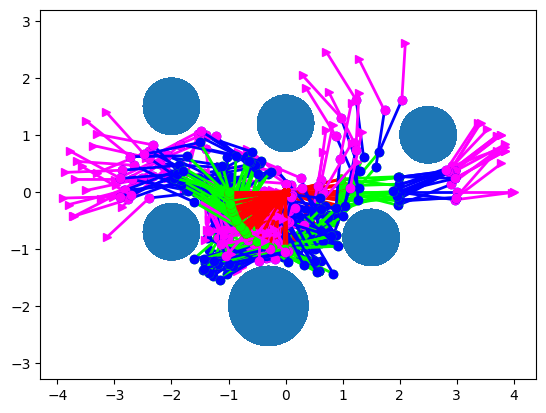

In [39]:
linspace_final = np.array(linspace_final_without_collision)

for state in [State(angles) for angles in linspace_final]:
    print(state.angles)
    env.state = state
    condition, point = env.check_collision(env.state)
    if (condition):
        print(
            f'Attention!!! Collision detected '
            f'in link {point['link_segment']} '
            f'joint on coordinates: {np.round(point['collision_point'], 2)}'
        )
    else:
        print('No collision detected')
    env.render(plt_show=False)

In [40]:
from anim import animate_plan

animate_plan(env, [State(angles) for angles in linspace_final])

Starting animation...
Animation saved to /Users/denis/PyEnv/Planning/planning_2024/PS2/solve_4R.mp4


### Task 2.C

On average, for our initial and goal points, RRT takes 2-4 minutes and provide 130-150 states trajectory.

But, to achieve this, it was required a lot spaces, based on log we can say that it was skipped at lease 21600 states due to collision. It's a lot.  

RRT doesn't guaranty that result will be optimal plan. Moreover, it's more chance that result will be not optimal. But, in my own opinion, RRT also is not good idea for multi-state agents. Because on sampling step it leads to complicated check-conditions and looking for neighbors. It something like "we have a lot computational resource - let's use it on maximum". Also, very important for manipulators and robotics in global, if we can provide robust, repeatable algorithm. And I don't found RRT such algorithm as well. 

### Task 2.D

With the introduction of the weighted distance function that emphasizes the angles of the first joints, the planner now prioritizes optimizing the motion of these initial joints in the manipulator. This change in focus alters the trajectory structure, making the movements of the first joints more predictable, while potentially leading to less optimal movements in the more distant joints, which carry less weight in the calculations.


From a practical standpoint, employing a weighted metric allows for consideration of the varying significance of different joints for specific tasks. However, this approach may compromise the overall optimality of the trajectory. This rephrasing maintains the original meaning while presenting it in a new way.

In [53]:
def rrt_array_algos_with_collision(
    state_space: Tree,
    q_goal: np.ndarray,
    obstacles: np.ndarray,
    collision_threshold: float = 0.1,
    node_bound=1,
    max_iterations=30000
):
    """
    RRT algorithm with collision avoidance and fallback to add nodes to the nearest leaf.

    :param state_space: The Tree object representing the state space.
    :param q_goal: The goal configuration as a numpy array.
    :param obstacles: Array representing obstacles in the environment.
    :param collision_threshold: Threshold for collision detection.
    :param node_bound: Maximum allowable distance for connecting nodes.
    :param max_iterations: Maximum iterations to grow the tree.
    :return: The path from start to goal as a list of configurations.
    """
    skip = 0
    test_env = ManipulatorEnv(
        obstacles=obstacles,
        initial_state=State(state_space.root.value),
        collision_threshold=collision_threshold
    )

    for iteration in range(max_iterations):
        # Check if we can directly connect to the goal
        if state_space.find_neighbor(state_space.root,
                                     q_goal,
                                     boundary=node_bound,
                                     custom_norm=True):
            print(f"Goal reached in {iteration + 1} iterations.")
            break

        # Generate a random configuration
        q_random = generate_random_state(
            q_goal=q_goal,
            state_space_root=state_space.root,
            method=1  # Global sampling
        )

        # Perform collision check
        test_env.state = State(q_random)
        condition, point = test_env.check_collision(test_env.state)
        if condition:
            skip += 1
            print(f"Skipped {skip} due to collision at {q_random}.")
            continue

        # Try to add the random configuration to the tree
        added = state_space.find_neighbor(state_space.root,
                                          np.round(q_random, 2),
                                          boundary=node_bound,
                                          custom_norm=True)
        if not added:
            # Fallback: Add a new node to the nearest leaf in the tree
            new_node = state_space.add_to_nearest_leaf(
                q_random, boundary=node_bound,
                env=test_env, norm_type=1
            )
            if new_node:
                print(f"Node added to the nearest leaf: {new_node.value}")

    # Find the goal node
    goal_node = state_space.find_node(state_space.root, q_goal)
    if goal_node:
        # Reconstruct the path
        path = reconstruct_array_path(goal_node)
        print(f"Shortest path: {path}")
        return path
    else:
        # print("Goal node not found!")
        return None

# Example input data
leaf_init = np.array([0.0, 0.0, 0.0, 0.0])
leaf_goal = np.array([-180.0, -60.0, 72.0, -60.0])

state_tree = Tree(leaf_init)

linspace_final_without_collision = rrt_array_algos_with_collision(
    state_space=state_tree,
    q_goal=leaf_goal,
    obstacles=np.array(data["obstacles"]),
    collision_threshold=data["collision_threshold"],
    node_bound=20
)

Skipped 1 due to collision at [-72.54466853  90.16069785 117.84070175 -87.25971923].
Skipped 2 due to collision at [-112.93667203 -103.76795507   55.24761495  170.81108404].
Skipped 3 due to collision at [ 141.97749373  126.66441495 -120.61372946  -40.41281555].
Skipped 4 due to collision at [  89.69989073 -138.71174818   91.33201013 -159.45769274].
Skipped 5 due to collision at [ 163.66372105  100.8227454  -127.35554065   96.88166591].
Skipped 6 due to collision at [-157.32742633  130.4179437    61.02652801  -80.14511398].
Node added to the nearest leaf: [  7.74852471 -20.         -20.          20.        ]
Skipped 7 due to collision at [-34.96940969  74.80800753 124.45591717 -61.99923478].
Skipped 8 due to collision at [168.26483909  96.54566697  40.76682487  -6.4387294 ].
Skipped 9 due to collision at [-107.58905964   47.94828172    5.43767155  176.53018048].
Skipped 10 due to collision at [ 98.04083767 -62.52317693 -93.85799922  45.25440677].
Skipped 11 due to collision at [-174.87

[0. 0. 0. 0.]
No collision detected
[  7.74852471 -20.         -20.          20.        ]
No collision detected
[ 27.74852471 -40.         -31.32949575   0.        ]
No collision detected
[ 14.99254244 -20.         -11.32949575 -20.        ]
No collision detected
[34.99254244  0.          8.67050425  0.        ]
No collision detected
[54.99254244 20.         28.67050425 20.        ]
No collision detected
[34.99254244 40.         48.67050425  0.        ]
No collision detected
[ 14.99254244  40.31081757  68.67050425 -20.        ]
No collision detected
[ -5.00745756  60.31081757  88.67050425 -31.19225604]
No collision detected
[-25.00745756  80.31081757  68.67050425 -11.19225604]
No collision detected
[ -5.00745756  60.31081757  88.67050425 -31.19225604]
No collision detected
[ 14.99254244  40.31081757  68.67050425 -11.19225604]
No collision detected
[ -5.00745756  60.31081757  85.87384619 -31.19225604]
No collision detected
[-25.00745756  80.31081757  65.87384619 -51.19225604]
No collisi

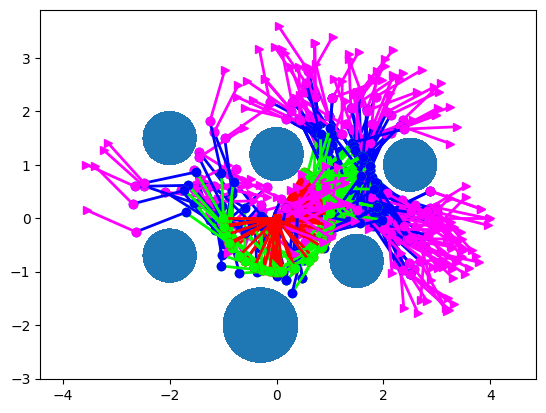

In [54]:
linspace_final = np.array(linspace_final_without_collision)

for state in [State(angles) for angles in linspace_final]:
    print(state.angles)
    env.state = state
    condition, point = env.check_collision(env.state)
    if (condition):
        print(
            f'Attention!!! Collision detected '
            f'in link {point['link_segment']} '
            f'joint on coordinates: {np.round(point['collision_point'], 2)}'
        )
    else:
        print('No collision detected')
    env.render(plt_show=False)

In [55]:
animate_plan(env, [State(angles) for angles in linspace_final], video_output_file='solve_4R.mp4')

Starting animation...
Animation saved to /Users/denis/PyEnv/Planning/planning_2024/PS2/solve_4R.mp4


### TASK 2.E

Increasing the RRT step size led to a decrease in both computation time and the number of trajectory points, as the planner navigates the space more assertively, which in turn minimizes the number of intermediate configurations. However, a larger step size may overlook critical configurations, particularly in intricate areas with tight passages between obstacles. This can heighten the risk of errors, such as crossing into obstacles, due to a lack of detail in the trajectory. Generally, a larger pitch is advantageous for simpler environments, but it necessitates careful consideration when dealing with dense or confined spaces. Striking a balance between pitch and safety is essential.

In [48]:
# Example input data
leaf_init = np.array([0.0, 0.0, 0.0, 0.0])
leaf_goal = np.array([-180.0, -60.0, 72.0, -60.0])

state_tree = Tree(leaf_init)

linspace_final_without_collision = rrt_array_algos_with_collision(
    state_space=state_tree,
    q_goal=leaf_goal,
    obstacles=np.array(data["obstacles"]),
    collision_threshold=data["collision_threshold"],
    node_bound=30
)

Skipped 1 due to collision at [ 58.69492688 101.64421738  16.24400702 -95.34736238].
Skipped 2 due to collision at [  10.42725089 -111.74026197 -161.32732907 -126.3057841 ].
Skipped 3 due to collision at [ 75.50892878 169.33699756  49.93477806 -89.26934975].
Node added to the nearest leaf: [30. 30. 30. 30.]
Skipped 4 due to collision at [ 86.80379281  75.57937317 162.29501703  60.3610527 ].
Node added to the nearest leaf: [48.5527537  0.         0.         0.       ]
Skipped 5 due to collision at [-165.91092211  -83.64113158  -70.38796042    0.58293483].
Skipped 6 due to collision at [  27.27579088  -97.27927306 -143.37963918  -25.25883925].
Skipped 7 due to collision at [ 109.61513963    1.65765803  100.48209615 -115.98715381].
Skipped 8 due to collision at [ 165.99102004 -126.73101431 -160.00471798  151.83299602].
Skipped 9 due to collision at [-86.9493209  -62.51009095 105.69695816 154.1172372 ].
Skipped 10 due to collision at [-60.96983452 133.49422481  15.5160477   86.34652606].
N

[0. 0. 0. 0.]
No collision detected
[30. 30. 30. 30.]
No collision detected
[48.5527537  0.         0.         0.       ]
No collision detected
[ 56.83  -1.61 -23.52 -26.16]
No collision detected
[ 43.40075721 -31.61       -53.52         3.84      ]
No collision detected
[ 49.05381607 -61.61       -23.52       -26.16      ]
No collision detected
[ 43.07574263 -56.80749183 -53.52        -7.69625705]
No collision detected
[ 59.62652819 -46.76625716 -83.52        22.30374295]
No collision detected
[ 45.18846246 -28.10992067 -77.4413806   -7.69625705]
No collision detected
[ 43.70749928 -53.2662499  -47.4413806    9.16533691]
No collision detected
[ 48.10517317 -53.94310812 -50.1176287   39.16533691]
No collision detected
[ 48.56509565 -54.44785156 -20.1176287   52.83270847]
No collision detected
[ 28.26810731 -58.18444344   9.8823713   22.83270847]
No collision detected
[ 32.83752153 -70.14130987  39.8823713   52.83270847]
No collision detected
[   2.83752153 -100.14130987    9.8823713   

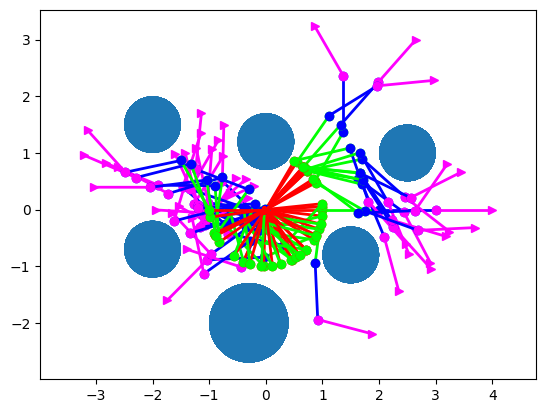

In [49]:
linspace_final = np.array(linspace_final_without_collision)

for state in [State(angles) for angles in linspace_final]:
    print(state.angles)
    env.state = state
    condition, point = env.check_collision(env.state)
    if (condition):
        print(
            f'Attention!!! Collision detected '
            f'in link {point['link_segment']} '
            f'joint on coordinates: {np.round(point['collision_point'], 2)}'
        )
    else:
        print('No collision detected')
    env.render(plt_show=False)